In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
path_to_ml_20m = "../data/ml-20m/"

In [25]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools
import time
import umap
import paths

def plot_pareto2(most_stable, all_stable_paths, save=False):
    # stabs = [p[1] for p in most_stable.values()]
    # lens = list(most_stable.keys())
        
    unoptimal_paths = np.array([(n, s[1]) for n, ps in all_stable_paths.items() for s in ps])
    optimal_paths = np.array([(n,ps[1]) for n, ps in most_stable.items()])

    ax = plt.figure(figsize=(20,10)).gca()  
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
    plt.subplot(111)
    
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 

    cmap = plt.get_cmap('tab10')
    plt.scatter(unoptimal_paths[:,0], unoptimal_paths[:,1], color=cmap(1), label='Nonoptimal paths')
    plt.scatter(optimal_paths[:,0], optimal_paths[:,1], label='Optimal paths')
    plt.plot(optimal_paths[:,0], optimal_paths[:,1], label='Pareto frontier')


    plt.xlabel("Length of path")
    plt.ylabel("Instability of path")

    plt.legend()
    ticks = range(int(min(optimal_paths[:,0])), int(max(optimal_paths[:,0])) + 1)
    plt.xticks(ticks)
    if save!=False:
        plt.savefig(save,)


#from cechmate import Cover
class BaseFiltration:
    def __init__(self, max_dim=3):
        self.max_dim = max_dim
        
        
class Cover(BaseFiltration):
    def build(self, covers):

        # Give each cover element a name.
        if not isinstance(covers, dict):
            covers = dict(enumerate(covers))

        simplices = [([k], 0.0) for k in covers.keys()]

        # TODO: be more intelligent about which combos we check

        #Changed self.max_dim+1 to self.max_dim+2. Correct?
        for k in range(2, self.max_dim + 2):
            for potentials in itertools.combinations(covers.keys(), k):
                potential_sets = [covers[p] for p in potentials]

                d = self.jaccard(potential_sets)

                # TODO: Do we want to include all of these simplices as well?
                if d < 1:
                    simplices.append((potentials, d))

        return simplices

    def jaccard(self, covers):
        covers_as_sets = list(map(set, covers))
        intersection = set.intersection(*covers_as_sets)
        union = set.union(*covers_as_sets)

        return 1 - len(intersection) / len(union)


__all__ = ['Cover']

%matplotlib inline

pd.options.display.max_rows = 8

## Choose 5 particular genres

In [6]:
"""
Possible genres:

Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
(no genres listed)
"""

MAJOR_CATS = ['Action', 'Drama', 'Comedy', 'Romance', 'Horror']
MAJOR_CATS = ['Adventure', "Children", "Musical", "Sci-Fi", "Western"]

# BAD_CATS = ['Film-Noir', '(no genre listed)']

## Load ratings

In [7]:
ratings = pd.read_csv(os.path.join(path_to_ml_20m, "ratings.csv"), delimiter=",")\
            .drop(columns=['timestamp'])
ratings = ratings.loc[ratings['rating']>= 3.5]
ratings

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
...,...,...,...
20000257,138493,68319,4.5
20000258,138493,68954,4.5
20000259,138493,69526,4.5
20000261,138493,70286,5.0


## Load movies information

In [8]:
movie_info = pd.read_csv(os.path.join(path_to_ml_20m, "movies.csv"), delimiter=",")
movie_info

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
...,...,...,...
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


In [9]:
movie_info.loc[movie_info.title.str.contains("Transformers")]
movie_info.loc[movie_info.title.str.contains("Notebook")]
movie_info.loc[movie_info.title.str.contains("Princess Brid")]
movie_info.loc[movie_info.title.str.contains("Donnie Darko")]
movie_info.loc[movie_info.title.str.contains("Chainsaw Massacre")]
movie_info.loc[movie_info.title.str.contains("Mulan")]
movie_info.loc[movie_info.title.str.contains("Moulin Rouge" )]

transformers = 53996
notebook = 8533
princess = 1197

darko = 4878
chainsaw = 6880

mulan = 1907 
rouge = 4308

- Transformers $\to$ The Notebook 
- The Princess Bride $\to$ Donnie Darko
- Texas Chainsaw Massacre $\to$ Mulan
- Mulan $\to$ Moulin Rouge

## Filter movies to only particular subset

- filter out lots of movies that won't matter 
- ones that only have a few ratings




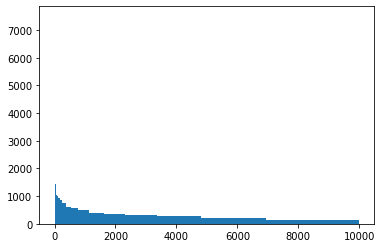

In [10]:
movies = ratings.groupby('movieId')
movies_map = {name: list(group.userId) for name, group in movies}
movies_ratings_n = [len(m) for m in movies_map.values()]
plt.hist(movies_ratings_n, bins=np.logspace(1,4,20)-10)
plt.show()

In [11]:
len(movies_ratings_n)
len([n for n in movies_ratings_n if n >= 10])

12988

In [12]:
slim_movies_map = {name: ls for name, ls in movies_map.items() if len(ls) >= 10}

transformers = 53996
notebook = 8533
princess = 1197
darko = 4878
chainsaw = 6880
mulan = 1907
rouge = 4308

good_movies = [transformers, notebook, princess, darko, chainsaw, mulan, rouge]
np.random.seed(1)

rate = 200. / len(movies_map)
slimer_movies_map = {name: ls for name, ls in movies_map.items() 
                     if np.random.random() <= rate or name in good_movies}

In [13]:
for m in good_movies:
    assert m in slimer_movies_map.keys()

In [14]:
filt = lambda x: '|'.join(set(x.split('|')).intersection(MAJOR_CATS))
isin = lambda x: len(set(x.split('|')).intersection(MAJOR_CATS)) > 0
def get_year(x):
    try:
        return int(x.strip()[-6:][1:-1])
    except:
        return 1


movie_info['year'] = movie_info['title'].apply(get_year)

# movie_info = movie_info[movie_info['year'] > 2000]
# movie_info['major_cat'] = movie_info['genres'].apply(isin)
# movie_info['genres'] = movie_info['genr es'].apply(filt)
# movie_info = movie_info[movie_info['major_cat'] == True]
movie_info

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
...,...,...,...,...
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,2002
27275,131258,The Pirates (2014),Adventure,2014
27276,131260,Rentun Ruusu (2001),(no genres listed),2001
27277,131262,Innocence (2014),Adventure|Fantasy|Horror,2014


## Sample only middle percentile of movie and user

based on number of users rating each movie, and number of movies each user rates.

In [15]:
def sample_middle_movies(ratings, lower=0.5, upper=0.95):
    """ Sample just middle percentiles of movies
    
    """
    movies = ratings.groupby('movieId')
    movies_map = {name: list(group.userId) for name, group in movies}

    movies_ratings_n = [len(m) for m in movies_map.values()]
    lower_bound, upper_bound = pd.Series(movies_ratings_n).quantile([lower, upper]).values
    print(f"Remove movies with # ratings <= {lower_bound} and # ratings >= {upper_bound}")

    movies_map = {name: mlist for name, mlist in movies_map.items() if lower_bound <= len(mlist) <= upper_bound}
    print(f"Was {len(movies_ratings_n)}, now {len(movies_map)} movies in the range.")
    
    return movies_map

def sample_middle_users(lower=0.5, upper=0.95):
    """ sample middle percentiles of users
    
    """
    users = ratings.groupby('userId')
    users_map = {name: list(group.movieId) for name, group in users}

    users_ratings_n = [len(m) for m in users_map.values()]
    lower_bound, upper_bound = pd.Series(users_ratings_n).quantile([lower, upper]).values
    print(f"Remove movies with # ratings <= {lower_bound} and # ratings >= {upper_bound}")

    users_map = {name: ulist for name, ulist in users_map.items() if lower_bound <= len(ulist) <= upper_bound}
    print(f"Was {len(users_ratings_n)}, now {len(users_map)} users in the range.")
    
    return users_map

def particular_movies_sample(ratings, n=500):
    
    # limit to only middle percentile users 
    users_map = sample_middle_users()
    ok_users = list(users_map.keys())
    sub_ratings = ratings[(ratings['userId'].isin(ok_users))]
    
    # Filter only particular movies
    print(f"--{len(sub_ratings)} movie reviews after filtering users")
    sub_ratings = sub_ratings[sub_ratings['movieId'].isin(movie_info.movieId)]
    print(f"--{len(sub_ratings)} movie reviews after filtering good movies")
    
    # Get movies with middle percentiles          
    movies_map = sample_middle_movies(sub_ratings)

    print("Sample movies")
    rate = n / len(movies_map)
    
    # then randomly sample the movies
    np.random.seed(1)
    movies_map = {m:l for m,l in movies_map.items() if np.random.random() <= rate}
    
    print(f"Resulting dataset has {len(movies_map)} movies")
    return movies_map

In [16]:
# movies_map = particular_movies_sample(ratings)

## Build cover and filtration from selected movies

In [17]:
def thresh_filt(filtration, thresh):
    filtration = [f for f in filtration if f[1] < thresh]
    return filtration
    
def build_graph(filtration, thresh=None):
    """ Build a networkx graph out of the 1-skeleton in the filtration
    """
    if thresh:
        filtration = thresh_filt(filtration, thresh)
    
    vertices = [s[0][0] for s in filtration if len(s[0]) == 1]
    edges = [s[0] for s in filtration if len(s[0]) == 2]
    edge_attrs = {s[0]: s[1] for s in filtration if len(s[0]) == 2}
    edge_weights = list(edge_attrs.values())
    
    g = nx.Graph()
    g.add_nodes_from(vertices)
    g.add_edges_from(edges)
    nx.set_edge_attributes(g, edge_attrs, 'dist')

    return g

In [18]:
start = time.time()
c = Cover(max_dim=1)
filtration = c.build(slimer_movies_map)

vertices = [s for s in filtration if len(s[0]) == 1]
edges = [s for s in filtration if len(s[0]) == 2]

# Make sure we have vertices and edges and no triangles
assert len(filtration) == len(vertices) + len(edges)
assert len(edges) > 0
g = build_graph(filtration)
end = time.time()
print(end-start)

2.4209980964660645


In [74]:
#Once a graph is generated, it can be saved and loaded through nx.write_gpickle and nx.read_gpickle. 

'''
import networkx as nx
nx.write_gpickle(g,'7000_sample_graph')

In [75]:
#g2=nx.read_gpickle('7000_sample_graph')

## Mulan $\to$ Mulan Rouge

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
import networkx as nx
from matplotlib.collections import LineCollection

# source, terminal = paths.utils.random_st(g, 1)
def movie_names_in_path(ms):
    movies_in_path = ms[0]
    pms = [movie_info.loc[movie_info.movieId == m].title.values[0] for m in movies_in_path]
    return pms

#Set save=True when calling to save output as files
def paths_demo(g, source, terminal,save=False):
    most_stable, all_stable_paths = paths.most_stable_paths(g, source, terminal)
    #paths.draw.plot_pareto(most_stable, all_stable_paths)
    plot_pareto2(most_stable, all_stable_paths, save=False)
    print(str(source))
    with open('Output/'+str(source)+'_'+str(terminal)+str(s)+'_samples.txt', 'a+') as f:
        for k, p in most_stable.items():
            print(p)
            print(k, ":\n\t", "\n\t".join(movie_names_in_path(p)))
            if save==True
                f.write(str(p))
                f.write(str(k)+":\n\t"+"\n\t")
                for movie in movie_names_in_path(p):
                    f.write(str(movie)+":\n\t"+"\n\t")
        

In [28]:
movie_info.loc[movie_info.movieId == 1907]

,movieId,title,genres,year
1823,1907,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musi...,1998


- Transformers $\to$ The Notebook 
- The Princess Bride $\to$ Donnie Darko
- Texas Chainsaw Massacre $\to$ Mulan
- Mulan $\to$ Moulin Rouge

- transformers = 53996
- notebook = 8533
- princess = 1197
- darko = 4878
- chainsaw = 6880
- mulan = 1907
- rouge = 4308

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


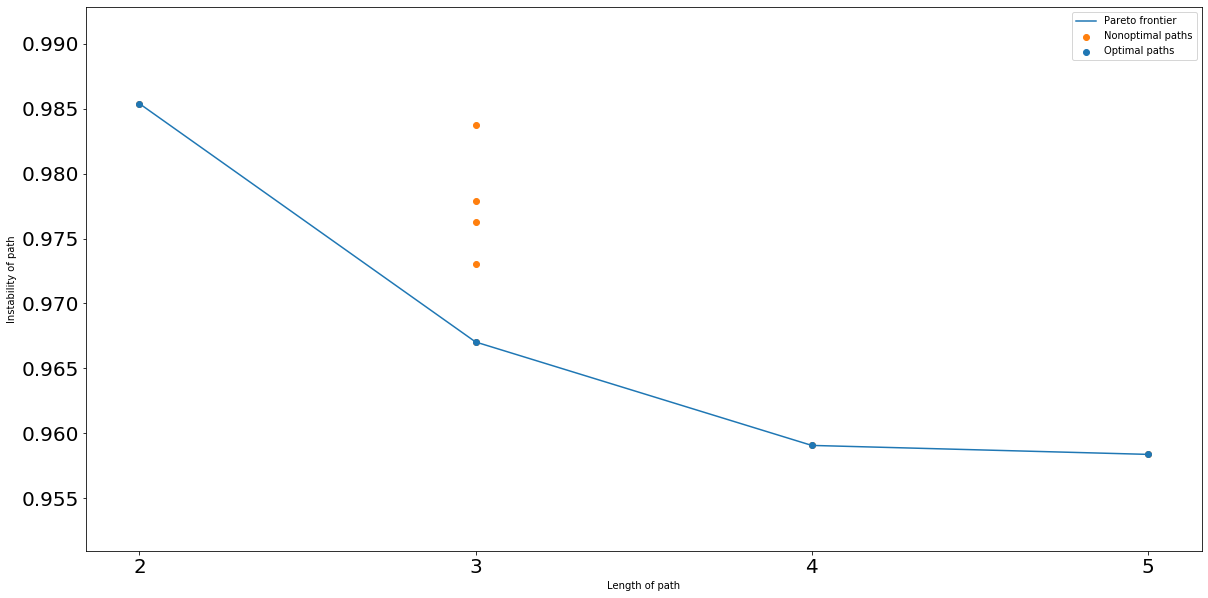

In [35]:
paths_demo(g, chainsaw, mulan)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


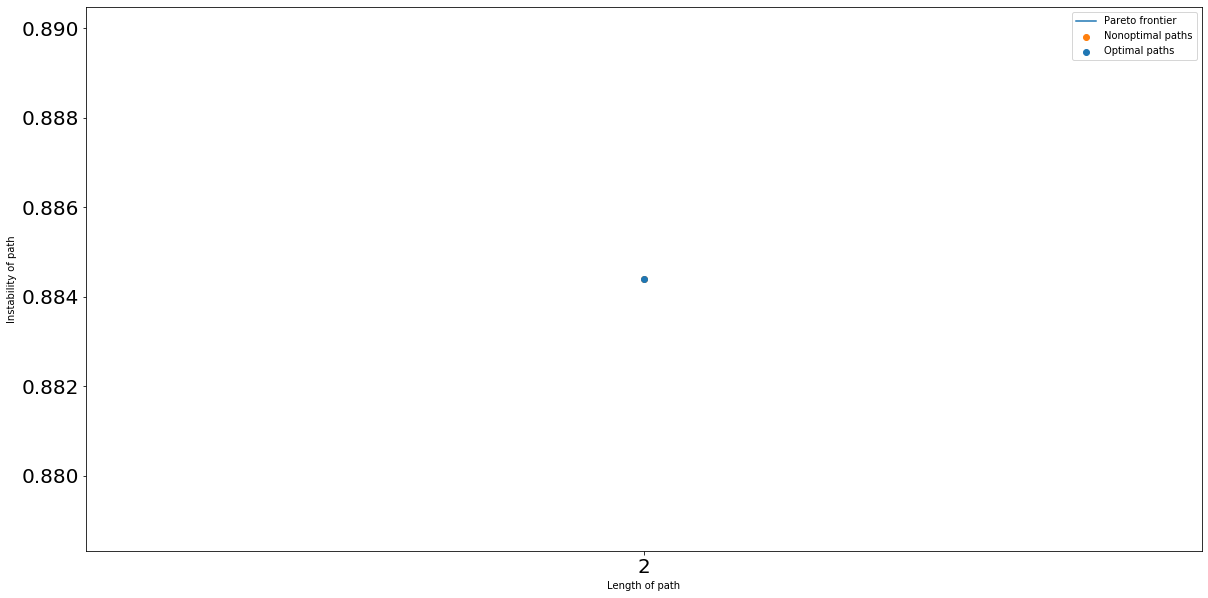

In [30]:
paths_demo(g, mulan, rouge)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


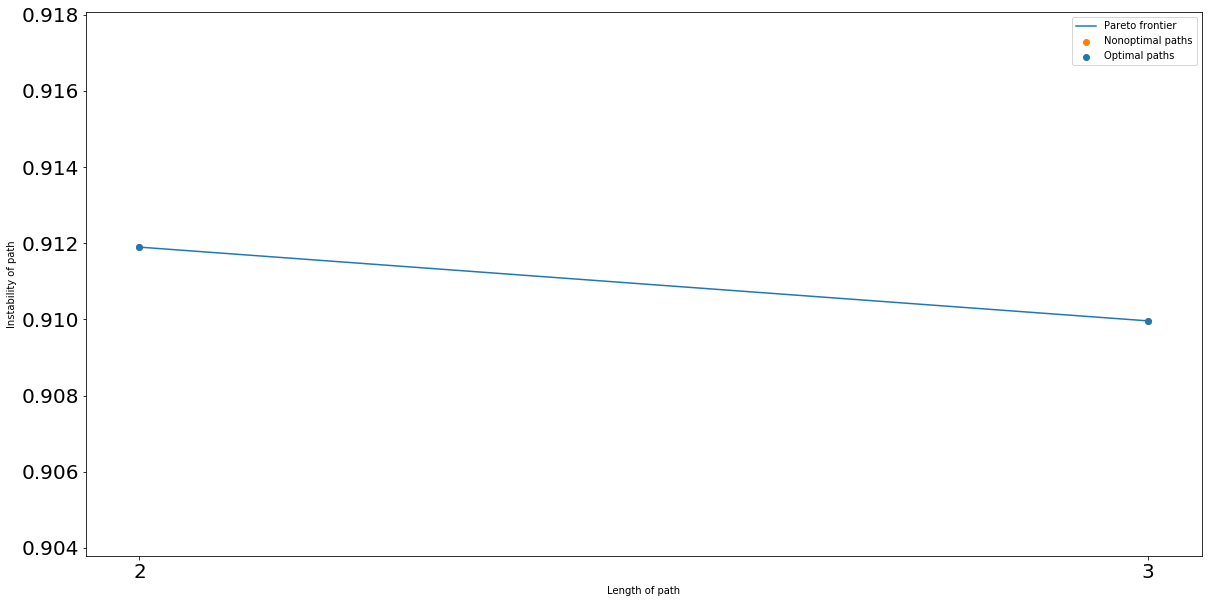

In [31]:
paths_demo(g, transformers, notebook)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


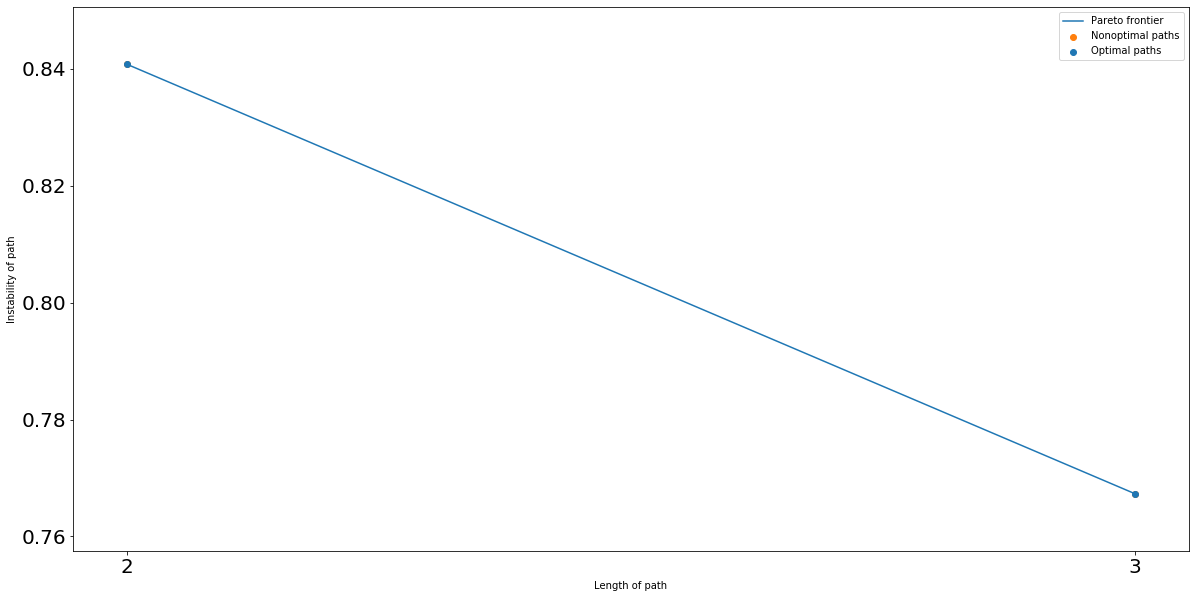

In [32]:
paths_demo(g, princess, darko)

## Compute pareto frontier between $s$ and $t$

/Users/matthewbroussard/Documents/GitHub/VereniceFiltrations/paths/draw.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111)


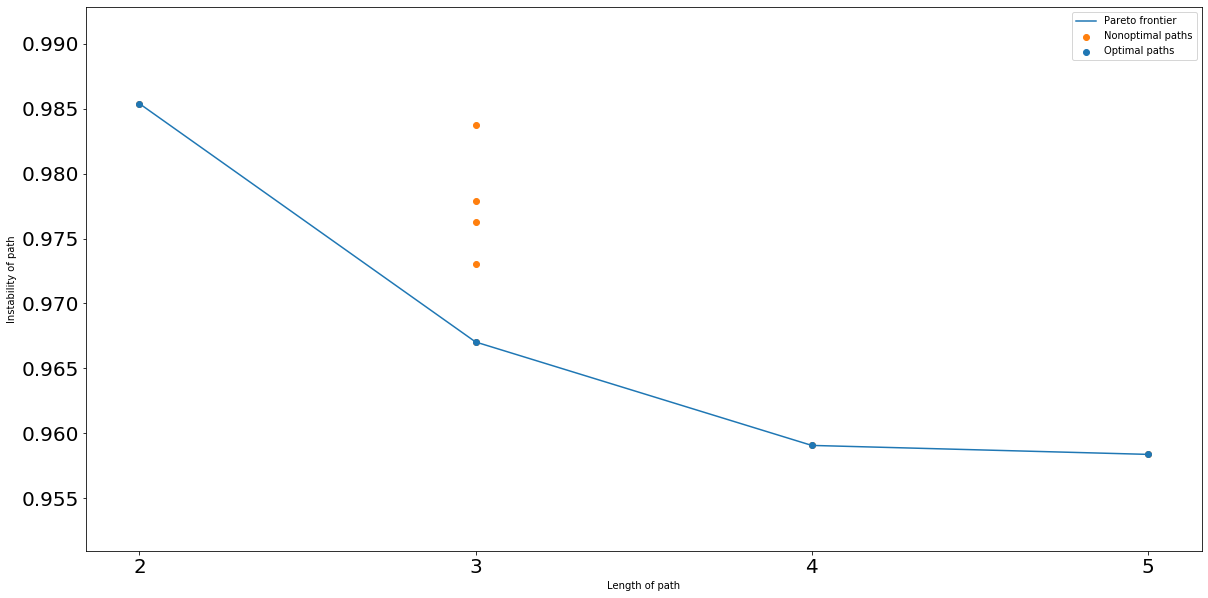

In [37]:
most_stable, all_stable_paths = paths.most_stable_paths(g, chainsaw, mulan)
paths.draw.plot_pareto(most_stable, all_stable_paths)
# plt.savefig("movies_pareto_1.png")

In [38]:
def movie_names_in_path(ms):
    movies_in_path = ms[0]
    pms = [movie_info.loc[movie_info.movieId == m].title.values[0] for m in movies_in_path]
    return pms

print("\n".join(movie_names_in_path(most_stable[2])))
print()
print("\n".join(movie_names_in_path(most_stable[3])))
print()
print("\n".join(movie_names_in_path(most_stable[4])))

Texas Chainsaw Massacre, The (2003)
Mulan (1998)

Texas Chainsaw Massacre, The (2003)
Transformers (2007)
Mulan (1998)

Texas Chainsaw Massacre, The (2003)
Scary Movie 2 (2001)
Transformers (2007)
Mulan (1998)


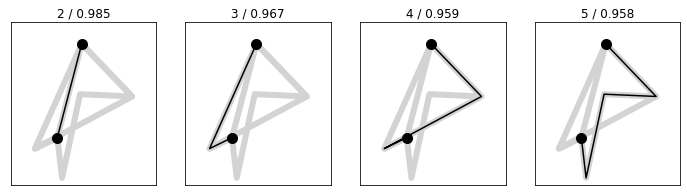

In [39]:
from matplotlib.collections import LineCollection

pos = nx.kamada_kawai_layout(g)
instability = np.array([v for _, v in most_stable.values()])

points = [np.array([pos[u] for u in path])
          for path, _ in most_stable.values()]

n = len(points)
s = 3

plt.figure(figsize=(s*n, s))
colors = np.array(['lightgray', 'black'])

for i, path in enumerate(points):
    background = LineCollection(points, linewidth=6, color='lightgray')
    lines = LineCollection([path], color='black')
    
    ax = plt.subplot(1, n, i + 1)
    ax.add_collection(background)
    ax.add_collection(lines)
    ax.scatter(*path[[0, -1]].T, s=100, c='k', zorder=2)
    ax.autoscale_view()

    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{len(points[i])} / {instability[i]:.3f}')
    
#plt.savefig('small_multiples_movies.png')

## Plot the pareto frontier on the graph using kamada kawaii and UMAP

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packag

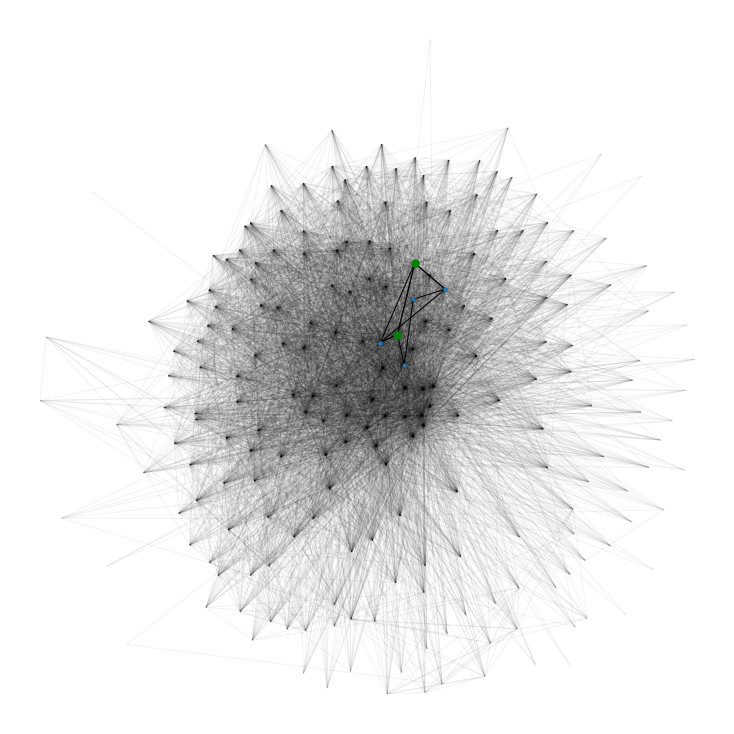

In [41]:
gcc = g.subgraph(max(nx.connected_components(g), key=len))
paths.draw.draw_stable_paths(gcc, most_stable, chainsaw, mulan)

In [42]:
def UMAP_positions(g, filtration):

    def distances_fast(g, vertices, vertex_map):
        """This shouldn't be used, it was a first pass, fast but not very accurate."""
        dists = np.zeros((len(vertices), len(vertices)))
        from itertools import combinations
        for s,e in combinations(vertices, 2):

            if (s,e) in g.edges:
                dists[vertex_map[e], vertex_map[s]] = g.edges[s,e]['dist']
                dists[vertex_map[s], vertex_map[e]] = g.edges[s,e]['dist']
            elif (e,s) in g.edges:
                print("edge backwards is in")
            else:
                dists[vertex_map[e], vertex_map[s]] = 10
                dists[vertex_map[s], vertex_map[e]] = 10

        return dists

    vertices = [v[0][0] for v in filtration if len(v[0]) == 1]
    vertex_map = {v:k for k,v in enumerate(vertices)}
    dists = distances_fast(g, vertices, vertex_map)
    print("Found distances")

    embedding = umap.UMAP(n_neighbors=10, metric='precomputed').fit_transform(dists)
    print("umap embedding computed")
    keys = np.array(list(vertex_map.keys()))
    pos = {k: embedding[v] for k,v in vertex_map.items()}
    
    return embedding, pos, keys

Found distances
umap embedding computed


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.6/site-packag

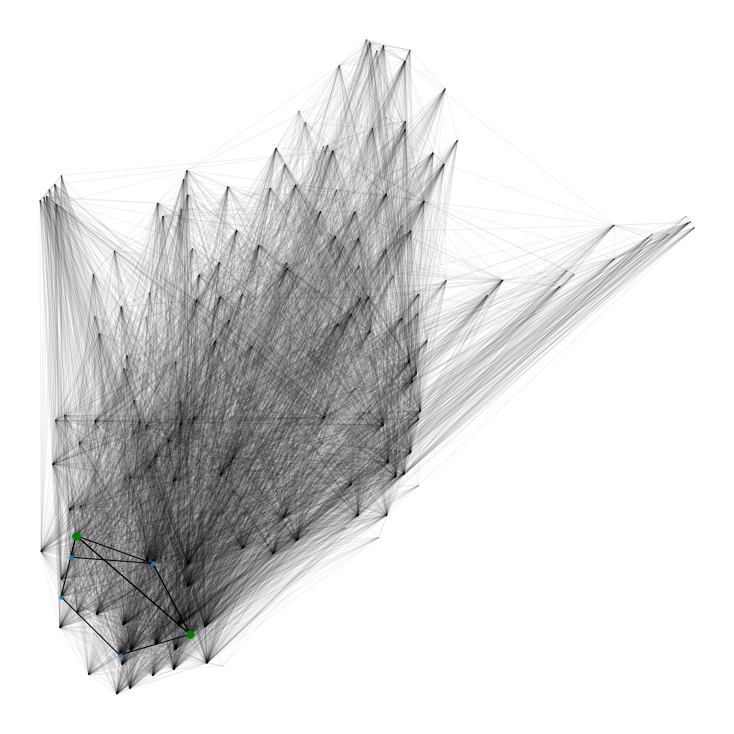

In [44]:
embedding, pos, keys = UMAP_positions(g, filtration)
paths.draw.draw_stable_paths(g, most_stable, chainsaw, mulan, pos=pos)

## Cluster the UMAP embedding and see how well it clustered

In [45]:
from sklearn import cluster

def genre_hist(genres_list, v, ax):
    from collections import Counter
    each = [g for x in genres_list for g in x.split('|')]
    c = dict(Counter(each))
    
    cs = []
    for m in MAJOR_CATS:
        if m in c.keys():
            cs.append(c[m])
        else:
            cs.append(0)
        
    cmap = plt.get_cmap("tab10")
    
    ax.bar(range(len(MAJOR_CATS)), cs, align='center', color=cmap(int(v)), alpha=0.5)
    ax.set_xticks(range(len(MAJOR_CATS)))
    ax.set_xticklabels( list(MAJOR_CATS), rotation=45 )

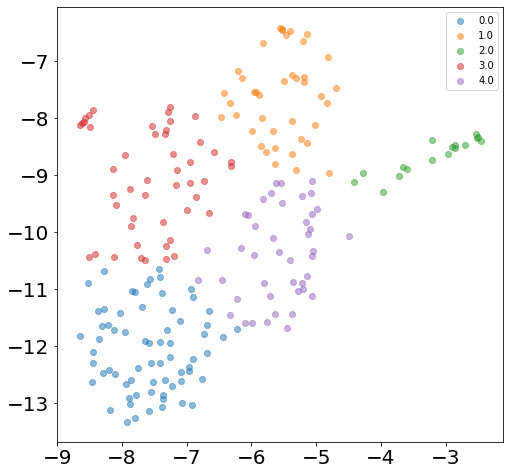

In [46]:
clusterer = cluster.KMeans(5)
clusterer.fit(embedding)

ds = np.hstack([keys.reshape(-1,1), embedding, clusterer.labels_.reshape(-1, 1)])
df = pd.DataFrame(ds, columns=['key', 'x', 'y', 'cluster'])
clusters = df.groupby('cluster')
plt.figure(figsize=(8,8))

for c, da in clusters:
    alpha = 0.5
    plt.scatter(*da[['x', 'y']].values.T, label=c, alpha=alpha)
plt.legend()

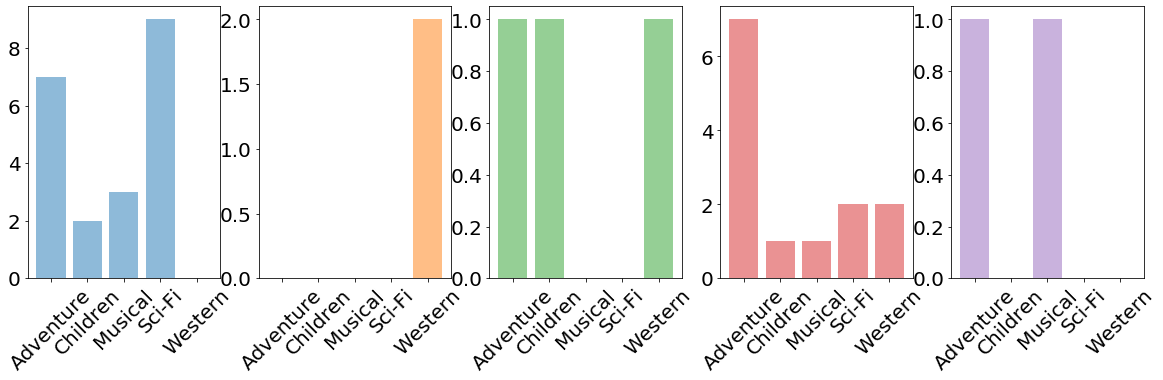

In [47]:
plt.figure(figsize=(20,5))

v = 0.0
ax = plt.subplot(151)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 1.0
ax = plt.subplot(152)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 2.0
ax = plt.subplot(153)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 3.0
ax = plt.subplot(154)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 4.0
ax = plt.subplot(155)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

## Look at some steps in the filtration 

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


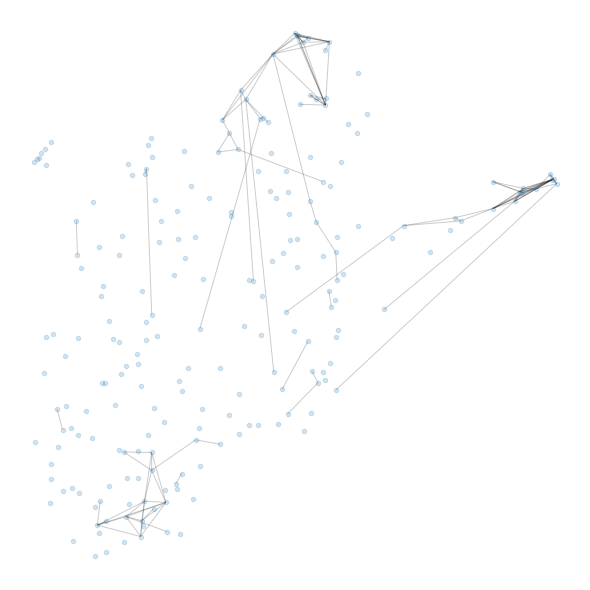

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


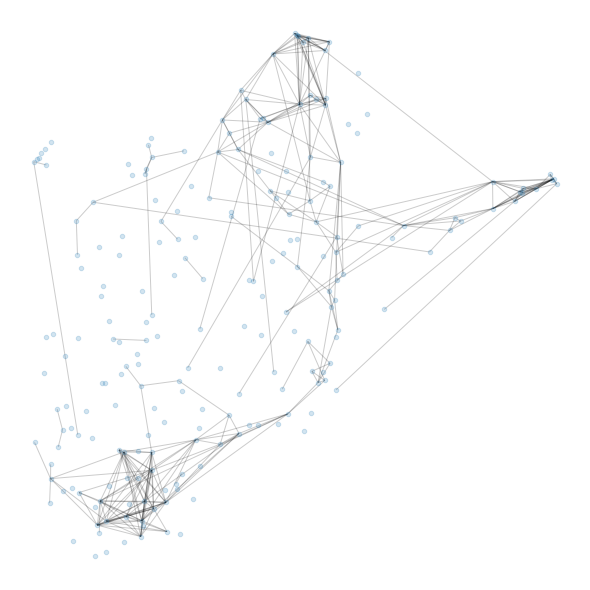

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


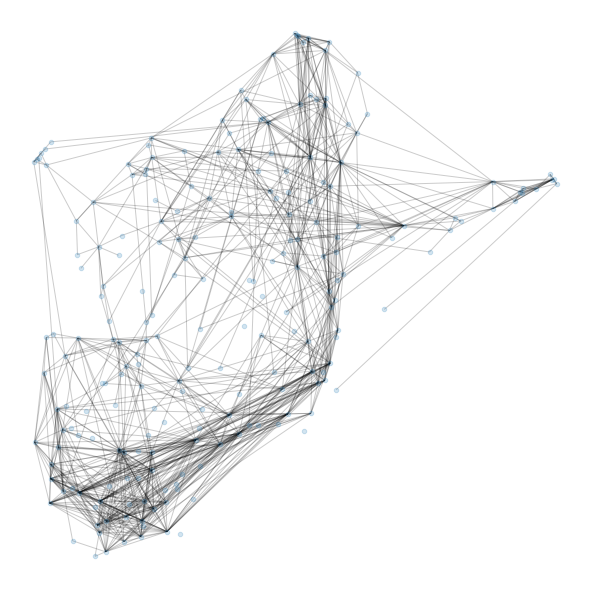

In [48]:
def filter_plot(filtration, thresh, pos=None):
    pos = pos or nx.kamada_kawai_layout()
    filtration = [f for f in filtration if f[1] < thresh]
    g = build_graph(filtration, thresh)
    
    plt.figure(figsize=(8,8))
    edges = g.edges()
    weights = [g[u][v]['dist'] for u,v in edges]
    nx.draw(g, pos=pos, node_size=20, alpha=0.2)
    plt.show()

filter_plot(filtration, 0.90, pos)
filter_plot(filtration, 0.95, pos)
filter_plot(filtration, 0.98, pos)